# Programming Assignment 1: Introduction to ML Workflow and Decision Trees


**Members:** Michael Hoon Yong Hau (yongm@chalmers.se), Chua Shan Hong (shanho@chalmers.se)

**PA1 Group 16**



#Task 1: A classification example: fetal heart condition diagnosis

##Reading the Data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the CSV file.
data = pd.read_csv('CTG.csv', skiprows=1)

# Select the relevant numerical columns.
selected_cols = ['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV',
                 'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean',
                 'Median', 'Variance', 'Tendency', 'NSP']
data = data[selected_cols].dropna()

# Shuffle the dataset.
data_shuffled = data.sample(frac=1.0, random_state=0)

# Split into input part X and output part Y.
X = data_shuffled.drop('NSP', axis=1)

# Map the diagnosis code to a human-readable label.
def to_label(y):
    return [None, 'normal', 'suspect', 'pathologic'][(int(y))]

Y = data_shuffled['NSP'].apply(to_label)

# Partition the data into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

X.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
658,130.0,1.0,0.0,3.0,0.0,0.0,0.0,24.0,1.2,12.0,...,35.0,120.0,155.0,1.0,0.0,134.0,133.0,135.0,1.0,0.0
1734,134.0,9.0,1.0,8.0,5.0,0.0,0.0,59.0,1.2,0.0,...,109.0,80.0,189.0,6.0,0.0,150.0,146.0,150.0,33.0,0.0
1226,125.0,1.0,0.0,4.0,0.0,0.0,0.0,43.0,0.7,31.0,...,21.0,120.0,141.0,0.0,0.0,131.0,130.0,132.0,1.0,0.0
1808,143.0,0.0,0.0,1.0,0.0,0.0,0.0,69.0,0.3,6.0,...,27.0,132.0,159.0,1.0,0.0,145.0,144.0,146.0,1.0,0.0
825,152.0,0.0,0.0,4.0,0.0,0.0,0.0,62.0,0.4,59.0,...,25.0,136.0,161.0,0.0,0.0,159.0,156.0,158.0,1.0,1.0


In [ ]:
X.shape

(2126, 21)

##Training the Baseline Classifier

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

clf = DummyClassifier(strategy='most_frequent') # using dummy classifier as a baseline
cross_val_score(clf, Xtrain, Ytrain) # cross validation over training set for classification accuracy

array([0.78235294, 0.78235294, 0.77941176, 0.77941176, 0.77941176])

We have a NumPy array that contains the accuracies on the (default 5) different folds in the cross-validation. Now we want to aggregate these scores to get a single score which we can use to compare different classifiers. We will be computing the mean accuracy across all the 5 folds using NumPy.

In [ ]:
import numpy as np

np.mean(cross_val_score(clf, Xtrain, Ytrain))

np.float64(0.7805882352941176)

Here we obtain a mean accuracy of **~78.05%** across all 5 folds.

## Trying Out Different Classifiers

The suggested classifiers are as follows:

Tree-based classifiers:

    sklearn.tree.DecisionTreeClassifier
    sklearn.ensemble.RandomForestClassifier
    sklearn.ensemble.GradientBoostingClassifier

Linear classifiers:

    sklearn.linear_model.Perceptron
    sklearn.linear_model.LogisticRegression
    sklearn.svm.LinearSVC

Neural network classifier (will take longer time to train):

    sklearn.neural_network.MLPClassifier

We will be attempting some of these to try and improve the cross-validation accuracy. Furthermore, to optimise the final accuracy we will be using hyperparameter tuning methods, specifically the `GridSearchCV`. This searches for the best combination of hyperparameters for a model by testing all possible combinations in a predefined grid. For each combination of hyperparameters in the grid, it runs `cross_val_score` internally. The final 3 chosen classifiers were the Decision Tree Classifier, the Random Forest Classifier, and the Gradient Boosting Classifier.


### Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
} # using grid of reasonable values

dtc = DecisionTreeClassifier(random_state=69)
grid_search = GridSearchCV(dtc, param_grid, cv=5, scoring='accuracy')
grid_search.fit(Xtrain, Ytrain)

print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

Best parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 10}
Best CV accuracy: 0.9376470588235293


The decision tree classifier yields a mean accuracy of **~93.8%**.

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'max_features': ['sqrt', 'log2']
} # using grid of reasonable values

rfc = RandomForestClassifier(random_state=69)
grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='accuracy')
grid_search.fit(Xtrain, Ytrain)

print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Best CV accuracy: 0.941764705882353


The random forest classifier yields a mean accuracy of **~94.2%**.

### Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
} # using grid of reasonable values

gbc = GradientBoostingClassifier(random_state=69)
grid_search = GridSearchCV(gbc, param_grid, cv=5, scoring='accuracy')
grid_search.fit(Xtrain, Ytrain)

print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Best CV accuracy: 0.951764705882353


The Gradient Boosting classifier yields a mean accuracy of **~95.2%**.

## Final Evaluation

From the above, the classifier that gives the highest accuracy is the **Gradient Boosting Classifier at 95.2%**. From the scikit-learn documentation, "*this algorithm builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions.*"

Gradient Boosting in essence is a form of **ensemble learning method** that builds a strong predictive model by combining **multiple weak learners** (usually decision trees) in a sequential, additive manner. Intuitively, it iteratively adds decision trees to correct the mistakes of the previous trees. Each new tree focuses on the residual errors of the existing ensemble, which refines the model's prediction iteratively. Furthermore, it has regularisation techniques such as tree depth limits (`max_depth`) to prevent overfitting. Thus, this model performed relatively well compared to the others and the baseline model.




 We will proceed to train the Gradient Boosting Classifier on the whole training set and evaluate it on the held-out test set.

In [ ]:
from sklearn.metrics import accuracy_score

clf = GradientBoostingClassifier(random_state=69, learning_rate=0.2, max_depth=3, n_estimators=100)

clf.fit(Xtrain, Ytrain)
Yguess = clf.predict(Xtest)

print(accuracy_score(Ytest, Yguess))

0.9225352112676056


The final accuracy score of the test set is **~92.3%**.

# Task 2: Decision trees for classification

Below shows the given code in the lecture for the `TreeClassifier`, and the respective base classes.

### Decision Tree Leaf

In [ ]:
class DecisionTreeLeaf:

    def __init__(self, value):
        self.value = value

    # This method computes the prediction for this leaf node. This will just return a constant value.
    def predict(self, x):
        return self.value

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_id = str(node_counter)
        val_str = f'{self.value:.4g}' if isinstance(self.value, float) else str(self.value)
        graph.node(node_id, val_str, style='filled')
        return node_counter+1, node_id

    def __eq__(self, other):
        if isinstance(other, DecisionTreeLeaf):
            return self.value == other.value
        else:
            return False

### Decision Tree Branch

In [ ]:
class DecisionTreeBranch:

    def __init__(self, feature, threshold, low_subtree, high_subtree):
        self.feature = feature
        self.threshold = threshold
        self.low_subtree = low_subtree
        self.high_subtree = high_subtree

    # For a branch node, we compute the prediction by first considering the feature, and then
    # calling the upper or lower subtree, depending on whether the feature is or isn't greater
    # than the threshold.
    def predict(self, x):
        if x[self.feature] <= self.threshold:
            return self.low_subtree.predict(x)
        else:
            return self.high_subtree.predict(x)

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_counter, low_id = self.low_subtree.draw_tree(graph, node_counter, names)
        node_counter, high_id = self.high_subtree.draw_tree(graph, node_counter, names)
        node_id = str(node_counter)
        fname = f'F{self.feature}' if names is None else names[self.feature]
        lbl = f'{fname} > {self.threshold:.4g}?'
        graph.node(node_id, lbl, shape='box', fillcolor='yellow', style='filled, rounded')
        graph.edge(node_id, low_id, 'False')
        graph.edge(node_id, high_id, 'True')
        return node_counter+1, node_id

### Decision Tree

In [ ]:
from graphviz import Digraph
from sklearn.base import BaseEstimator, ClassifierMixin
from abc import ABC, abstractmethod

class DecisionTree(ABC, BaseEstimator):

    def __init__(self, max_depth):
        super().__init__()
        self.max_depth = max_depth

    # As usual in scikit-learn, the training method is called *fit*. We first process the dataset so that
    # we're sure that it's represented as a NumPy matrix. Then we call the recursive tree-building method
    # called make_tree (see below).
    def fit(self, X, Y):
        if isinstance(X, pd.DataFrame):
            self.names = X.columns
            X = X.to_numpy()
        elif isinstance(X, list):
            self.names = None
            X = np.array(X)
        else:
            self.names = None
        Y = np.array(Y)
        self.root = self.make_tree(X, Y, self.max_depth)

    def draw_tree(self):
        graph = Digraph()
        self.root.draw_tree(graph, 0, self.names)
        return graph

    # By scikit-learn convention, the method *predict* computes the classification or regression output
    # for a set of instances.
    # To implement it, we call a separate method that carries out the prediction for one instance.
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        return [self.predict_one(x) for x in X]

    # Predicting the output for one instance.
    def predict_one(self, x):
        return self.root.predict(x)

    # This is the recursive training
    def make_tree(self, X, Y, max_depth):

        # We start by computing the default value that will be used if we'll return a leaf node.
        # For classifiers, this will be the most common value in Y.
        default_value = self.get_default_value(Y)

        # First the two base cases in the recursion: is the training set completely
        # homogeneous, or have we reached the maximum depth? Then we need to return a leaf.

        # If we have reached the maximum depth, return a leaf with the majority value.
        if max_depth == 0:
            return DecisionTreeLeaf(default_value)

        # If all the instances in the remaining training set have the same output value,
        # return a leaf with this value.
        if self.is_homogeneous(Y):
            return DecisionTreeLeaf(default_value)

        # Select the "most useful" feature and split threshold. To rank the "usefulness" of features,
        # we use one of the classification or regression criteria.
        # For each feature, we call best_split (defined in a subclass). We then maximize over the features.
        n_features = X.shape[1]
        _, best_feature, best_threshold = max(self.best_split(X, Y, feature) for feature in range(n_features))

        if best_feature is None:
            return DecisionTreeLeaf(default_value)

        # Split the training set into subgroups, based on whether the selected feature is greater than
        # the threshold or not
        X_low, X_high, Y_low, Y_high = self.split_by_feature(X, Y, best_feature, best_threshold)

        # Build the subtrees using a recursive call. Each subtree is associated
        # with a value of the feature.
        low_subtree = self.make_tree(X_low, Y_low, max_depth-1)
        high_subtree = self.make_tree(X_high, Y_high, max_depth-1)

        if low_subtree == high_subtree:
            return low_subtree

        # Return a decision tree branch containing the result.
        return DecisionTreeBranch(best_feature, best_threshold, low_subtree, high_subtree)

    # Utility method that splits the data into the "upper" and "lower" part, based on a feature
    # and a threshold.
    def split_by_feature(self, X, Y, feature, threshold):
        low = X[:,feature] <= threshold
        high = ~low
        return X[low], X[high], Y[low], Y[high]

    # The following three methods need to be implemented by the classification and regression subclasses.

    @abstractmethod
    def get_default_value(self, Y):
        pass

    @abstractmethod
    def is_homogeneous(self, Y):
        pass

    @abstractmethod
    def best_split(self, X, Y, feature):
        pass

### Criterion Definitions

In [ ]:
def majority_sum_scorer(n_low, low_distr, n_high, high_distr):
    maj_sum_low = low_distr.most_common(1)[0][1]
    maj_sum_high = high_distr.most_common(1)[0][1]
    return maj_sum_low + maj_sum_high

def entropy(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return -sum(p*np.log2(p) if p > 0 else 0 for p in ps)

def info_gain_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*entropy(low_distr)+n_high*entropy(high_distr))/(n_low+n_high)

def gini_impurity(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return 1-sum(p**2 for p in ps)

def gini_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*gini_impurity(low_distr)+n_high*gini_impurity(high_distr))/(n_low+n_high)

### Tree Classifier

In [ ]:
from collections import Counter

class TreeClassifier(DecisionTree, ClassifierMixin):

    def __init__(self, max_depth=10, criterion='maj_sum'):
        super().__init__(max_depth)
        self.criterion = criterion

    def fit(self, X, Y):
        # For decision tree classifiers, there are some different ways to measure
        # the homogeneity of subsets.
        if self.criterion == 'maj_sum':
            self.criterion_function = majority_sum_scorer
        elif self.criterion == 'info_gain':
            self.criterion_function = info_gain_scorer
        elif self.criterion == 'gini':
            self.criterion_function = gini_scorer
        else:
            raise Exception(f'Unknown criterion: {self.criterion}')
        super().fit(X, Y)
        self.classes_ = sorted(set(Y))

    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the most common value.
    def get_default_value(self, Y):
        self.class_distribution = Counter(Y)
        return self.class_distribution.most_common(1)[0][0]

    # Checks whether a set of output values is homogeneous. In the classification case,
    # this means that all output values are identical.
    # We assume that we called get_default_value just before, so that we can access
    # the class_distribution attribute. If the class distribution contains just one item,
    # this means that the set is homogeneous.
    def is_homogeneous(self, Y):
        return len(self.class_distribution) == 1

    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):

        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])
        X_sorted = list(X[sorted_indices, feature])
        Y_sorted = list(Y[sorted_indices])

        n = len(Y)

        # The frequency tables corresponding to the parts *before and including*
        # and *after* the current element.
        low_distr = Counter()
        high_distr = Counter(Y)

        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None

        # Go through all the positions (excluding the last position).
        for i in range(0, n-1):

            # Input and output at the current position.
            x_i = X_sorted[i]
            y_i = Y_sorted[i]

            # Update the frequency tables.
            low_distr[y_i] += 1
            high_distr[y_i] -= 1

            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            #x_next = XY[i+1][0]
            x_next = X_sorted[i+1]
            if x_i == x_next:
                continue

            # Compute the homogeneity criterion for a split at this position.
            score = self.criterion_function(i+1, low_distr, n-i-1, high_distr)

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(X_sorted[max_i] + X_sorted[max_i+1])
        return max_score, feature, split_point

### Testing on Defined Class TreeClassifier

Similar to above, we seek to tune the hyperparameter `max_depth` to get the best cross-validation performance, and then evaluate the classifier on the test set. We will use the `gini` criterion for homogeneity measurement.

In [ ]:
param_grid = {
    'max_depth': [3, 5, 7, 10, 12, 15, 17, None]
} # using grid of reasonable values

tcls = TreeClassifier(criterion='gini')
grid_search = GridSearchCV(tcls, param_grid, cv=5, scoring='accuracy')
grid_search.fit(Xtrain, Ytrain)

print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-31-aa1c9057e343>", line 20, in fit
    super().fit(X, Y)
  File "<ipython-input-30-d95c0cf9f34a>", line 24, in fit
    self.root = self.make_tree(X, Y, self.max_depth)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-30-d95c0cf9f34a>", line 77, in make_tree
    low_su

Best parameters: {'max_depth': 7}
Best CV accuracy: 0.9329411764705882


From the above, we see that the best value for `max_depth` is 7, with an accuracy of **~93.3%**.

In [ ]:
# evaluating on test set with the best max_depth of 7
tcls = TreeClassifier(criterion='gini', max_depth=7)
tcls.fit(Xtrain, Ytrain)
Yguess = tcls.predict(Xtest)

print(accuracy_score(Ytest, Yguess))

0.9131455399061033


Evaluating on the test set, we obtain an accuracy score of **~91.3%**.

## Visualising the Tree Classifier

We will set `max_depth` to a reasonably small value of 3 just for illustration purposes below

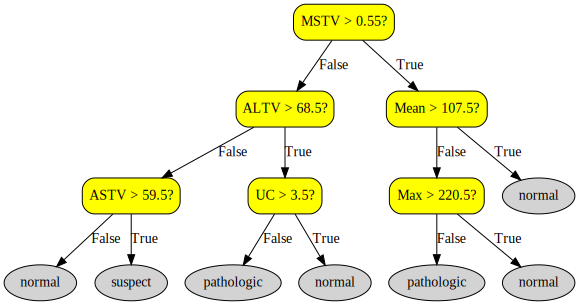

In [ ]:
tcls_illus = TreeClassifier(criterion='gini', max_depth=3)
tcls_illus.fit(Xtrain, Ytrain)
tcls_illus.draw_tree()

# Task 3: A regression example: predicting property prices

We will be using the given dataset about property prices in parts of Sweden, from Hemnet, and the code snippet given to load the data, find a suitable model using cross-validation over the training set, and finally evaluate on the held-out test data.

The goal is to **predict the price of an apartment**, given numerical information such as the number of rooms, the size of the apartment in square meters, the floor, etc.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Read the Excel file using Pandas.
alldata = pd.read_excel('Hemnet_data.xlsx')

# # Convert the timestamp string to an integer representing the year.
alldata['year'] = pd.DatetimeIndex(alldata['Sold Date']).year

# Convert 'yes' to 1 and 'no' to 0
alldata['Balcony'] = alldata['Balcony'].map({'Yes': 1, 'No': 0})
alldata['Patio'] = alldata['Patio'].map({'Yes': 1, 'No': 0})
alldata['Lift'] = alldata['Lift'].map({'Yes': 1, 'No': 0})

# Select the 12 input columns and the output column.
selected_columns = ['Final Price (kr)', 'year',  'Num of Room', 'Living Area (m²)', 'Balcony', 'Patio','Current Floor', 'Total Floor', 'Lift', 'Built Year', 'Fee (kr/month)', 'Operating Fee (kr/year)']
alldata = alldata[selected_columns]
alldata = alldata.dropna()

# we have to somehow manually handle the 'kr' currency symbol in the data as it is messing up the regressor input for Xtrain
for col in ['Fee (kr/month)', 'Operating Fee (kr/year)']:
    if alldata[col].dtype == 'object':  # check if the column is object type (string)
        alldata[col] = alldata[col].str.replace('kr', '', regex=False).astype(float)

# Shuffle.
alldata_shuffled = alldata.sample(frac=1.0, random_state=0)

# Separate the input and output columns.
X = alldata_shuffled.drop('Final Price (kr)', axis=1)
# For the output, we'll use the log of the sales price.
Y = alldata_shuffled['Final Price (kr)'].apply(np.log)

# Split into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

Xtrain.head()

,year,Num of Room,Living Area (m²),Balcony,Patio,Current Floor,Total Floor,Lift,Built Year,Fee (kr/month),Operating Fee (kr/year)
29679,2024.0,2.0,65.0,1,0,5.0,8.0,1,1992.0,NaN,3500.0
3610,2024.0,3.0,73.5,1,0,2.0,3.0,1,1992.0,NaN,6240.0
17000,2024.0,2.0,42.5,1,0,3.0,4.0,0,1937.0,NaN,4200.0
25221,2024.0,3.0,84.0,1,0,2.0,2.0,0,1972.0,NaN,6739.0
3248,2024.0,2.0,63.0,1,0,1.0,3.0,0,1957.0,NaN,6360.0


## Training & Evaluating a Baseline Dummy Regressor

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
m1 = DummyRegressor()
cross_validate(m1, Xtrain, Ytrain, scoring='neg_mean_squared_error')

{'fit_time': array([0.00352931, 0.004318  , 0.00244236, 0.00234818, 0.00236273]),
 'score_time': array([0.00138593, 0.00127649, 0.00119019, 0.0011549 , 0.00113559]),
 'test_score': array([-0.35548711, -0.35827597, -0.31759722, -0.34236524, -0.35596055])}

Again, we seek to aggregate the test scores and obtain a reference value for the negative mean squared error to evaluate the subsequent regressors. We note that the `cross_validate` function returns the negative mean squared error here due to scikit-learn's convention of maximising score, and a lower MSE value is better.

To obtain an aggregate value, we take the mean of the `test_score` array multiplied by `-1` to convert it back into MSE. This gives the average MSE across all 5 folds. We also want to calculate the **standard deviation** of the MSEs which would show the variability in performance across folds, which is useful for assessing model consistency.

In [ ]:
mean_mse = np.mean(-cross_validate(m1, Xtrain, Ytrain, scoring='neg_mean_squared_error')['test_score'])

std_mse = np.std(-cross_validate(m1, Xtrain, Ytrain, scoring='neg_mean_squared_error')['test_score'])

print(f"Baseline MSE: {mean_mse:.3f} ± {std_mse:.3f}")

Baseline MSE: 0.346 ± 0.015


We see that we now have a baseline MSE value of 0.346 and a standard deviation of 0.015, meaning that the below models trained should theoretically achieve a **lower** MSE value than this baseline.

## Training Better Regressors

Similar to the previous task, we will be training on the three following regressor models:

1. DecisionTreeRegressor
2. RandomForestRegressor
3. GradientBoostingRegressor

and performing hyperparameter tuning on each one of them to find the optimal parameters.

To avoid repetition again for the training of all 3 models, we will use a helper function to evaluate the models. This function performs `GridSearchCV` and returns the best model class, the best MSE value, the parameters used for that model, and the final MSE of the test set evaluation.

In [ ]:
from sklearn.metrics import mean_squared_error

def evaluate_model(model, param_grid, Xtrain, Ytrain, Xtest, Ytest):
    grid_search = GridSearchCV(model, param_grid,
                              cv=5,
                              scoring='neg_mean_squared_error',
                              n_jobs=-1) # for parallelisation i think, using all CPU cores for faster eval
    grid_search.fit(Xtrain, Ytrain)

    best_model = grid_search.best_estimator_
    best_mse = -grid_search.best_score_  # convert back to positive MSE
    best_params = grid_search.best_params_

    y_pred = best_model.predict(Xtest)
    test_mse = mean_squared_error(Ytest, y_pred)

    return best_params, best_mse, test_mse

### Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

gb_param_grid = {
    'gradientboostingregressor__n_estimators': [100, 200], # change variable names to avoid formatting error for pipeline
    'gradientboostingregressor__learning_rate': [0.05, 0.1],
    'gradientboostingregressor__max_depth': [3, 5],
    'gradientboostingregressor__subsample': [0.8, 1.0]
} # using some reasonable grid values

#  pipeline with mean imputation to fix NaN error as GBR does not natively support it
pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    GradientBoostingRegressor(random_state=69)
)

gb_params, gb_mse, gb_mse = evaluate_model(
    pipeline,
    gb_param_grid,
    Xtrain, Ytrain,
    Xtest, Ytest
)

print("Gradient Boosting Results:")
print(f"Best Parameters: {gb_params}")
print(f"CV MSE: {gb_mse:.4f}")
print(f"Test RMSE: {gb_mse:.4f}\n")

Gradient Boosting Results:
Best Parameters: {'gradientboostingregressor__learning_rate': 0.05, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__n_estimators': 200, 'gradientboostingregressor__subsample': 0.8}
CV MSE: 0.1417
Test RMSE: 0.1417



### Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'max_features': ['sqrt', 'log2']
}

rf_params, rf_mse, rf_mse = evaluate_model(
    RandomForestRegressor(random_state=69),
    rf_param_grid,
    Xtrain, Ytrain,
    Xtest, Ytest
)

print("Random Forest Results:")
print(f"Best Parameters: {rf_params}")
print(f"CV MSE: {rf_mse:.4f}")
print(f"Test RMSE: {rf_mse:.4f}\n")

Random Forest Results:
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
CV MSE: 0.1435
Test RMSE: 0.1435



### Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dt_param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10]
}

dt_params, dt_mse, dt_mse = evaluate_model(
    DecisionTreeRegressor(random_state=0),
    dt_param_grid,
    Xtrain, Ytrain,
    Xtest, Ytest
)

print("Decision Tree Results:")
print(f"Best Parameters: {dt_params}")
print(f"CV MSE: {dt_mse:.4f}")
print(f"Test RMSE: {dt_mse:.4f}")

Decision Tree Results:
Best Parameters: {'max_depth': 7, 'min_samples_split': 5}
CV MSE: 0.1719
Test RMSE: 0.1719


## Regressor Evaluation

From the above, since we used the helper function to evaluate all the 3 regressor models, we see that the Gradient Boosting Regressor performed the best with the **lowest test MSE score** of 0.1417. Hyperparameter tuning yields the following optimal parameters:

1. `learning_rate = 0.05` (From scikit-learn: "*Learning rate shrinks the contribution of each tree by learning_rate.*")
2. `max_depth = 5` (Maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree.)
3. `n_estimators = 200` (The number of estimators as selected by early stopping)
4. `subsample = 0.8` (The fraction of samples to be used for fitting the individual base learners. If smaller than 1.0 this results in **Stochastic Gradient Boosting**.)

This is to be expected as Gradient Boosting methods generally perform well and are resistant to overfitting.